### Experiment with Transformer based model for PAMAP2 ZSL training
__Transformer Encoder__ \
__Word Embedding Semantic Space__ \
_Objectives_ :
- transformer semantic feature output model hyper-param tuning
- 5-fold cross-validation tuning
- data normalization / not
- positional encoding 
- loss function tuning 

In [10]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import torch 
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import TSTransformerEncoderClassiregressor
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [16]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 8,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

In [3]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [5]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [13]:
# import action features
# feat_size = 64
# n_actions = 18 
# feat_mat = np.random.randn(n_actions, feat_size) 

# Load Glove-50 word embedding features 
feat_mat = np.load('./data/PAMAP2_Dataset/glove_features.npy')
n_actions, feat_size = feat_mat.shape

In [14]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]


eval: 100%|██████████| 26/26 [00:00<00:00, 67.53batch/s, loss=0.127]


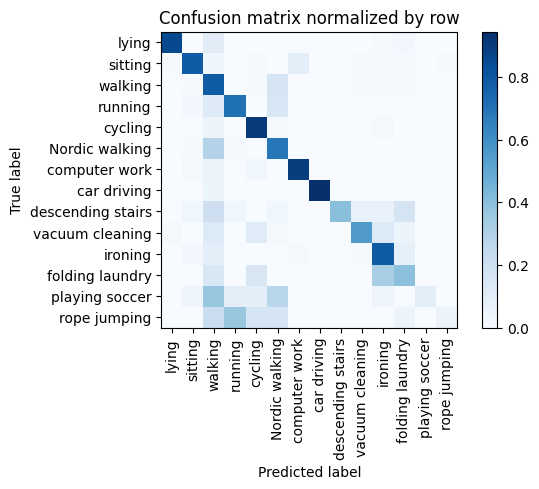

Training Epoch:  10%|█         | 1/10 [00:03<00:33,  3.74s/it]

Overall accuracy: 0.724

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.927      0.894      0.910      0.139        113|	 walking: 0.053,	cycling: 0.035,	
          ironing       0.786      0.786      0.786      0.137        112|	 walking: 0.089,	folding laundry: 0.080,	
          walking       0.453      0.785      0.575      0.114         93|	 Nordic walking: 0.161,	folding laundry: 0.011,	
   Nordic walking       0.628      0.684      0.655      0.097         79|	 walking: 0.291,	running: 0.013,	
            lying       0.970      0.853      0.908      0.092         75|	 walking: 0.107,	folding laundry: 0.027,	
          sitting       0.853      0.784      0.817      0.091         74|	 computer work: 0.095,	walking: 0.041,	
  vacuum cleaning       0.872      0.548      0.673      0.076         62|	 ironing: 0.129,	walking: 0.129,	
          cycling       0.699      0.911      0.791      0.069         56|	 walkin

eval: 100%|██████████| 26/26 [00:00<00:00, 64.52batch/s, loss=0.17]


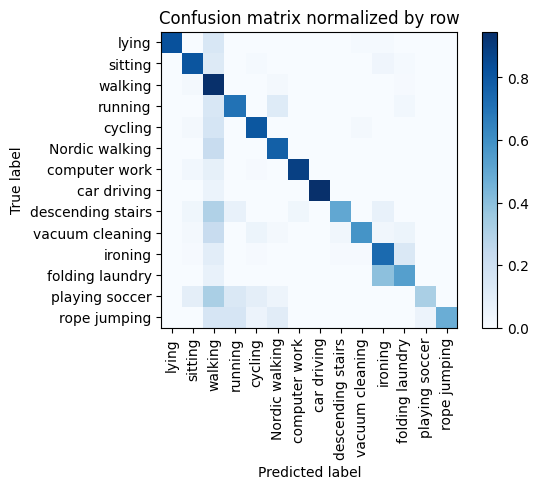

Training Epoch:  20%|██        | 2/10 [00:07<00:29,  3.65s/it]

Overall accuracy: 0.762

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.990      0.885      0.935      0.139        113|	 walking: 0.080,	sitting: 0.027,	
          ironing       0.812      0.732      0.770      0.137        112|	 folding laundry: 0.134,	walking: 0.098,	
          walking       0.449      0.946      0.609      0.114         93|	 Nordic walking: 0.022,	sitting: 0.022,	
   Nordic walking       0.859      0.772      0.813      0.097         79|	 walking: 0.228,	rope jumping: 0.000,	
            lying       1.000      0.827      0.905      0.092         75|	 walking: 0.147,	ironing: 0.013,	
          sitting       0.845      0.811      0.828      0.091         74|	 walking: 0.122,	ironing: 0.041,	
  vacuum cleaning       0.923      0.581      0.713      0.076         62|	 walking: 0.226,	folding laundry: 0.048,	
          cycling       0.833      0.804      0.818      0.069         56|	 walking: 0.161,

eval: 100%|██████████| 26/26 [00:00<00:00, 67.71batch/s, loss=0.0906]


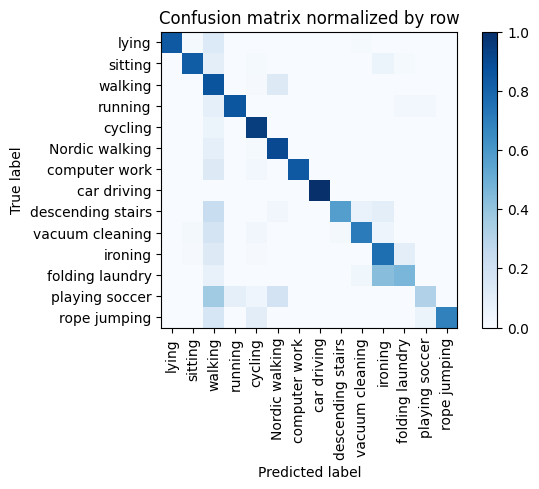

Training Epoch:  30%|███       | 3/10 [00:10<00:25,  3.62s/it]

Overall accuracy: 0.796

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       1.000      0.841      0.913      0.139        113|	 walking: 0.133,	cycling: 0.027,	
          ironing       0.794      0.759      0.776      0.137        112|	 walking: 0.125,	folding laundry: 0.098,	
          walking       0.471      0.860      0.608      0.114         93|	 Nordic walking: 0.129,	cycling: 0.011,	
   Nordic walking       0.807      0.899      0.850      0.097         79|	 walking: 0.089,	cycling: 0.013,	
            lying       1.000      0.840      0.913      0.092         75|	 walking: 0.133,	vacuum cleaning: 0.013,	
          sitting       0.953      0.824      0.884      0.091         74|	 walking: 0.095,	ironing: 0.054,	
  vacuum cleaning       0.917      0.710      0.800      0.076         62|	 walking: 0.177,	ironing: 0.048,	
          cycling       0.815      0.946      0.876      0.069         56|	 walking: 0.054,	rope

eval: 100%|██████████| 26/26 [00:00<00:00, 65.66batch/s, loss=0.0809]


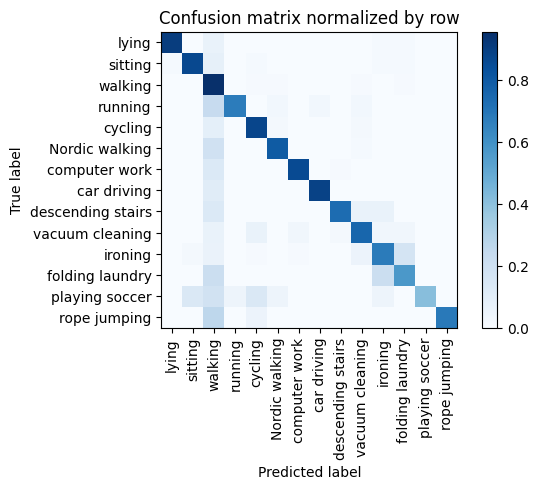

Training Epoch:  40%|████      | 4/10 [00:14<00:21,  3.57s/it]

Overall accuracy: 0.800

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.970      0.858      0.911      0.139        113|	 walking: 0.133,	descending stairs: 0.009,	
          ironing       0.854      0.679      0.756      0.137        112|	 folding laundry: 0.170,	walking: 0.062,	
          walking       0.509      0.957      0.664      0.114         93|	 folding laundry: 0.011,	vacuum cleaning: 0.011,	
   Nordic walking       0.940      0.797      0.863      0.097         79|	 walking: 0.190,	vacuum cleaning: 0.013,	
            lying       0.986      0.907      0.944      0.092         75|	 walking: 0.067,	folding laundry: 0.013,	
          sitting       0.928      0.865      0.895      0.091         74|	 walking: 0.081,	folding laundry: 0.014,	
  vacuum cleaning       0.797      0.758      0.777      0.076         62|	 cycling: 0.065,	walking: 0.065,	
          cycling       0.817      0.875      0.845      0.06

eval: 100%|██████████| 26/26 [00:00<00:00, 45.02batch/s, loss=0.115]


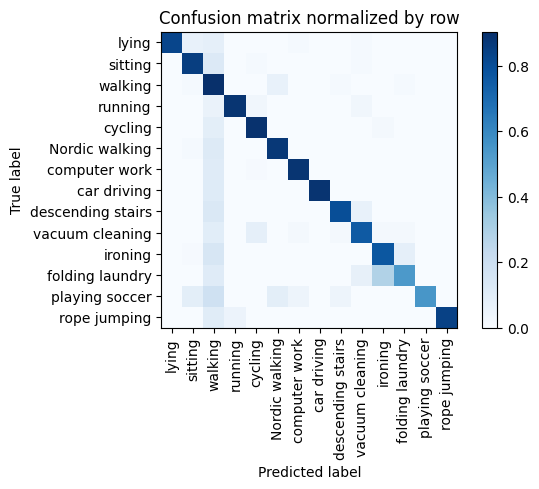

Training Epoch:  50%|█████     | 5/10 [00:18<00:19,  3.81s/it]

Overall accuracy: 0.827

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.971      0.885      0.926      0.139        113|	 walking: 0.106,	cycling: 0.009,	
          ironing       0.896      0.768      0.827      0.137        112|	 walking: 0.143,	folding laundry: 0.080,	
          walking       0.512      0.903      0.654      0.114         93|	 Nordic walking: 0.065,	folding laundry: 0.011,	
   Nordic walking       0.896      0.873      0.885      0.097         79|	 walking: 0.114,	sitting: 0.013,	
            lying       1.000      0.827      0.905      0.092         75|	 walking: 0.080,	sitting: 0.067,	
          sitting       0.863      0.851      0.857      0.091         74|	 walking: 0.122,	vacuum cleaning: 0.014,	
  vacuum cleaning       0.870      0.758      0.810      0.076         62|	 walking: 0.097,	cycling: 0.081,	
          cycling       0.862      0.893      0.877      0.069         56|	 walking: 0.0

eval: 100%|██████████| 26/26 [00:00<00:00, 64.68batch/s, loss=0.077]


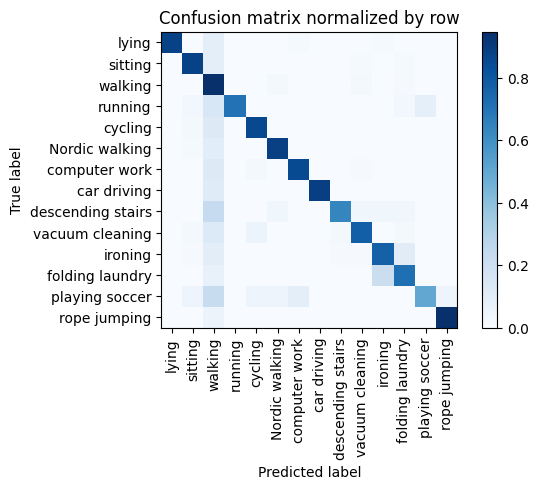

Training Epoch:  60%|██████    | 6/10 [00:22<00:15,  3.94s/it]

Overall accuracy: 0.828

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.970      0.850      0.906      0.139        113|	 walking: 0.124,	cycling: 0.018,	
          ironing       0.915      0.768      0.835      0.137        112|	 folding laundry: 0.107,	walking: 0.098,	
          walking       0.512      0.946      0.664      0.114         93|	 vacuum cleaning: 0.022,	Nordic walking: 0.022,	
   Nordic walking       0.946      0.886      0.915      0.097         79|	 walking: 0.101,	sitting: 0.013,	
            lying       1.000      0.880      0.936      0.092         75|	 walking: 0.093,	ironing: 0.013,	
          sitting       0.915      0.878      0.897      0.091         74|	 walking: 0.095,	folding laundry: 0.014,	
  vacuum cleaning       0.889      0.774      0.828      0.076         62|	 walking: 0.129,	cycling: 0.048,	
          cycling       0.889      0.857      0.873      0.069         56|	 walking: 0.1

eval: 100%|██████████| 26/26 [00:00<00:00, 66.50batch/s, loss=0.0805]


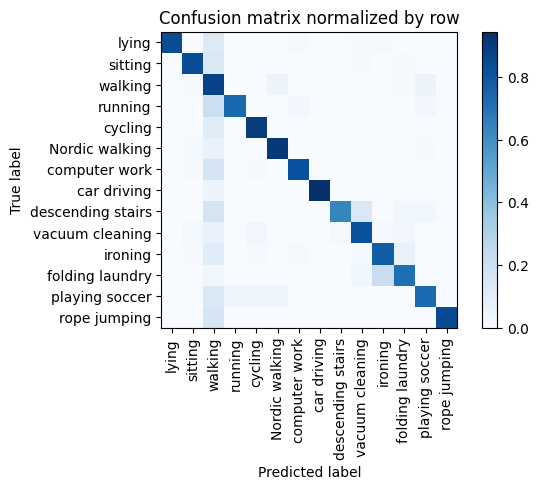

Training Epoch:  70%|███████   | 7/10 [00:26<00:11,  3.86s/it]

Overall accuracy: 0.825

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.969      0.823      0.890      0.139        113|	 walking: 0.159,	cycling: 0.009,	
          ironing       0.916      0.777      0.841      0.137        112|	 walking: 0.107,	folding laundry: 0.071,	
          walking       0.491      0.871      0.628      0.114         93|	 playing soccer: 0.054,	Nordic walking: 0.054,	
   Nordic walking       0.923      0.911      0.917      0.097         79|	 walking: 0.063,	playing soccer: 0.013,	
            lying       1.000      0.840      0.913      0.092         75|	 walking: 0.120,	ironing: 0.013,	
          sitting       0.925      0.838      0.879      0.091         74|	 walking: 0.135,	folding laundry: 0.014,	
  vacuum cleaning       0.850      0.823      0.836      0.076         62|	 walking: 0.065,	folding laundry: 0.032,	
          cycling       0.909      0.893      0.901      0.069         56|

eval: 100%|██████████| 26/26 [00:00<00:00, 61.76batch/s, loss=0.0855]


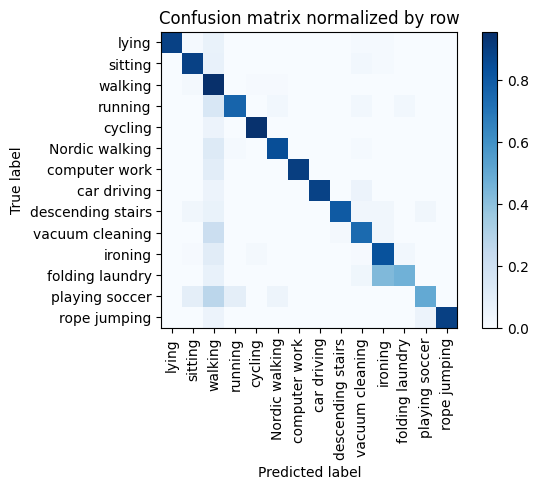

Training Epoch:  80%|████████  | 8/10 [00:30<00:07,  3.85s/it]

Overall accuracy: 0.847

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       1.000      0.903      0.949      0.139        113|	 walking: 0.097,	rope jumping: 0.000,	
          ironing       0.845      0.830      0.838      0.137        112|	 walking: 0.107,	folding laundry: 0.027,	
          walking       0.539      0.957      0.690      0.114         93|	 sitting: 0.022,	Nordic walking: 0.011,	
   Nordic walking       0.957      0.848      0.899      0.097         79|	 walking: 0.127,	vacuum cleaning: 0.013,	
            lying       1.000      0.893      0.944      0.092         75|	 walking: 0.067,	ironing: 0.013,	
          sitting       0.904      0.892      0.898      0.091         74|	 walking: 0.068,	vacuum cleaning: 0.027,	
  vacuum cleaning       0.836      0.742      0.786      0.076         62|	 walking: 0.210,	ironing: 0.032,	
          cycling       0.946      0.946      0.946      0.069         56|	 walking

eval: 100%|██████████| 26/26 [00:00<00:00, 49.34batch/s, loss=0.0775]


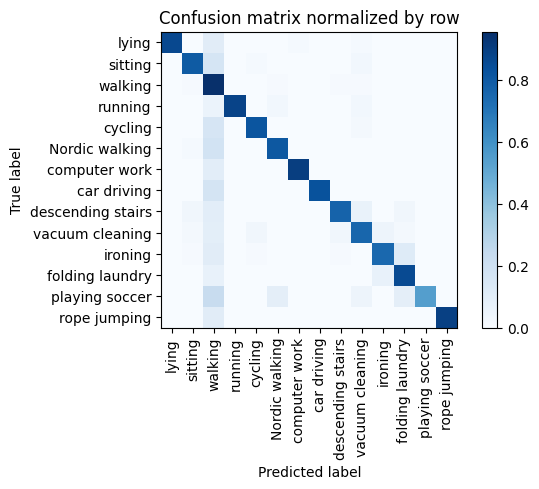

Training Epoch:  90%|█████████ | 9/10 [00:34<00:03,  3.90s/it]

Overall accuracy: 0.831

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.990      0.903      0.944      0.139        113|	 walking: 0.097,	rope jumping: 0.000,	
          ironing       0.944      0.750      0.836      0.137        112|	 folding laundry: 0.116,	walking: 0.107,	
          walking       0.500      0.957      0.657      0.114         93|	 vacuum cleaning: 0.011,	descending stairs: 0.011,	
   Nordic walking       0.941      0.810      0.871      0.097         79|	 walking: 0.177,	sitting: 0.013,	
            lying       1.000      0.867      0.929      0.092         75|	 walking: 0.107,	vacuum cleaning: 0.013,	
          sitting       0.922      0.797      0.855      0.091         74|	 walking: 0.162,	vacuum cleaning: 0.027,	
  vacuum cleaning       0.839      0.758      0.797      0.076         62|	 walking: 0.097,	ironing: 0.048,	
          cycling       0.920      0.821      0.868      0.069         5

eval: 100%|██████████| 26/26 [00:00<00:00, 67.89batch/s, loss=0.0527]


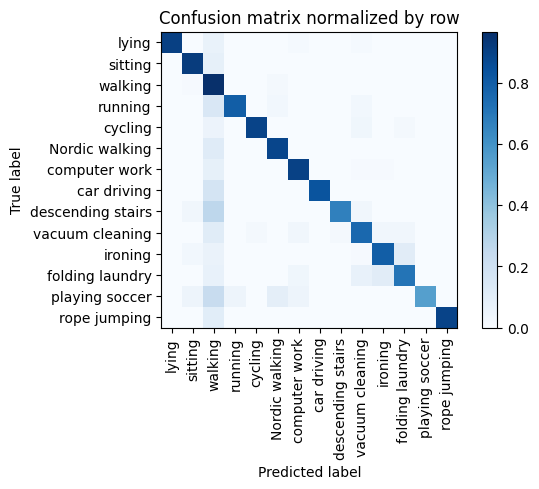

Overall accuracy: 0.853

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.953      0.903      0.927      0.139        113|	 walking: 0.080,	ironing: 0.009,	
          ironing       0.937      0.795      0.860      0.137        112|	 folding laundry: 0.107,	walking: 0.062,	
          walking       0.559      0.968      0.709      0.114         93|	 Nordic walking: 0.022,	sitting: 0.011,	
   Nordic walking       0.933      0.886      0.909      0.097         79|	 walking: 0.114,	rope jumping: 0.000,	
            lying       1.000      0.907      0.951      0.092         75|	 walking: 0.067,	vacuum cleaning: 0.013,	
          sitting       0.919      0.919      0.919      0.091         74|	 walking: 0.081,	rope jumping: 0.000,	
  vacuum cleaning       0.839      0.758      0.797      0.076         62|	 walking: 0.113,	folding laundry: 0.032,	
          cycling       0.980      0.893      0.935      0.069         56|	 wa

eval: 100%|██████████| 28/28 [00:00<00:00, 83.09batch/s, loss=0.268]


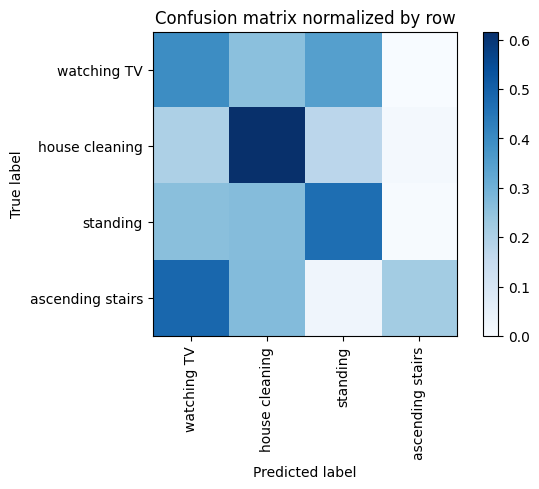

Overall accuracy: 0.461

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.585      0.468      0.520      0.337        295|	 house cleaning: 0.268,	watching TV: 0.261,	
  house cleaning       0.539      0.616      0.575      0.336        294|	 watching TV: 0.201,	standing: 0.173,	
ascending stairs       0.900      0.221      0.355      0.186        163|	 watching TV: 0.485,	house cleaning: 0.270,	
     watching TV       0.186      0.395      0.253      0.142        124|	 standing: 0.347,	house cleaning: 0.258,	

----------------------------------------------------------------------------------------------------
     avg / total       0.571      0.461      0.470        1.0        876|	      

{'total_accuracy': 0.4611872146118721, 'precision': 0.5522605748771003, 'recall': 0.42486576367524875, 'f1': 0.4254085771114759}


In [17]:
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = TSTransformerEncoderClassiregressor(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=False)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=False)
    print(test_metrics)
    print("="*40)
    break